In [1]:
import json

with open("../data/raw/data.json", "r") as f:
    data = json.load(f)

type(data)

data.keys()

dict_keys(['metadata', 'timeseries'])

In [34]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd

# open imported tmep min data from date to a year past
records = data["timeseries"]
df = pd.DataFrame(records)
df.head()

,PRCP,SNWD,TMAX,SNOW,TMIN
1968-06-01,0.00,0.0,70.0,0.0,51.0
1968-06-02,0.00,0.0,76.0,0.0,57.0
1968-06-03,0.00,0.0,74.0,0.0,55.0
1968-06-04,0.02,0.0,78.0,0.0,54.0
1968-06-05,0.00,0.0,76.0,0.0,54.0


In [3]:
df.index = pd.to_datetime(df.index)
df.index.name = "date"
df = df.sort_index()

df.info()
df.describe()

<class 'pandas.DataFrame'>
DatetimeIndex: 21063 entries, 1968-06-01 to 2026-01-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PRCP    21057 non-null  float64
 1   SNWD    20974 non-null  float64
 2   TMAX    21044 non-null  float64
 3   SNOW    20991 non-null  float64
 4   TMIN    20990 non-null  float64
dtypes: float64(5)
memory usage: 987.3 KB


,PRCP,SNWD,TMAX,SNOW,TMIN
count,21057.000000,20974.000000,21044.000000,20991.000000,20990.000000
mean,0.135345,0.338324,63.446731,0.074637,43.394712
std,0.371700,1.567704,18.683399,0.640831,16.968509
min,0.000000,0.000000,0.000000,0.000000,-13.000000
25%,0.000000,0.000000,48.000000,0.000000,30.000000
50%,0.000000,0.000000,65.000000,0.000000,43.000000
75%,0.060000,0.000000,80.000000,0.000000,58.000000
max,7.960000,25.000000,105.000000,19.800000,80.000000


In [4]:
# create the lag windows
df["TMIN_next"] = df["TMIN"].shift(-1)
df["TMIN_lag1"] = df["TMIN"].shift(1)
df["TMIN_lag7"] = df["TMIN"].shift(7)
df["TMAX_lag1"] = df["TMAX"].shift(1)

# drops missing rows
df = df.dropna()

In [5]:
df[[
    "TMIN",
    "TMIN_lag1",
    "TMIN_lag7",
    "TMAX_lag1",
    "TMIN_next"
]].head()

,TMIN,TMIN_lag1,TMIN_lag7,TMAX_lag1,TMIN_next
date,,,,,
1968-06-08,66.0,66.0,51.0,91.0,63.0
1968-06-09,63.0,66.0,57.0,92.0,67.0
1968-06-10,67.0,63.0,55.0,80.0,55.0
1968-06-11,55.0,67.0,54.0,88.0,55.0
1968-06-12,55.0,55.0,54.0,67.0,64.0


In [6]:
# naive predictor
df["pred_baseline"] = df["TMIN_lag1"]

# time-aware train/test split
train = df.loc[:'2015']
test = df.loc['2016':]

In [35]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(
    test["TMIN_next"],
    test["pred_baseline"]
)

print("Baseline MAE:", mae)

Baseline MAE: 7.0575402236160345


Baseline MAE 7.057 means our naive guess is around ~7*F off.
Add NOAA Edison TMIN data and initial exploration notebook.

In [8]:
features = [
    "TMIN_lag1",
    "TMIN_lag7",
    "TMAX_lag1"
]

# placing features as the input
X_train = train[features]
y_train = train["TMIN_next"]

X_test = test[features]
y_test = test["TMIN_next"]

In [9]:
from sklearn.linear_model import Ridge

model = Ridge(alpha=1.0)

# modeling weights
model.fit(X_train, y_train)

,"alpha alpha: {float, ndarray of shape (n_targets,)}, default=1.0Constant that multiplies the L2 term, controlling regularizationstrength. `alpha` must be a non-negative float i.e. in `[0, inf)`.When `alpha = 0`, the objective is equivalent to ordinary leastsquares, solved by the :class:`LinearRegression` object. For numericalreasons, using `alpha = 0` with the `Ridge` object is not advised.Instead, you should use the :class:`LinearRegression` object.If an array is passed, penalties are assumed to be specific to thetargets. Hence they must correspond in number.",1.0
,"fit_intercept fit_intercept: bool, default=TrueWhether to fit the intercept for this model. If setto false, no intercept will be used in calculations(i.e. ``X`` and ``y`` are expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"max_iter max_iter: int, default=NoneMaximum number of iterations for conjugate gradient solver.For 'sparse_cg' and 'lsqr' solvers, the default value is determinedby scipy.sparse.linalg. For 'sag' solver, the default value is 1000.For 'lbfgs' solver, the default value is 15000.",None
,"tol tol: float, default=1e-4The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for each solver:- 'svd': `tol` has no impact.- 'cholesky': `tol` has no impact.- 'sparse_cg': norm of residuals smaller than `tol`.- 'lsqr': `tol` is set as atol and btol of scipy.sparse.linalg.lsqr, which control the norm of the residual vector in terms of the norms of matrix and coefficients.- 'sag' and 'saga': relative change of coef smaller than `tol`.- 'lbfgs': maximum of the absolute (projected) gradient=max|residuals| smaller than `tol`... versionchanged:: 1.2 Default value changed from 1e-3 to 1e-4 for consistency with other linear models.",0.0001
,"solver solver: {'auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'}, default='auto'Solver to use in the computational routines:- 'auto' chooses the solver automatically based on the type of data.- 'svd' uses a Singular Value Decomposition of X to compute the Ridge coefficients. It is the most stable solver, in particular more stable for singular matrices than 'cholesky' at the cost of being slower.- 'cholesky' uses the standard :func:`scipy.linalg.solve` function to obtain a closed-form solution.- 'sparse_cg' uses the conjugate gradient solver as found in :func:`scipy.sparse.linalg.cg`. As an iterative algorithm, this solver is more appropriate than 'cholesky' for large-scale data (possibility to set `tol` and `max_iter`).- 'lsqr' uses the dedicated regularized least-squares routine :func:`scipy.sparse.linalg.lsqr`. It is the fastest and uses an iterative procedure.- 'sag' uses a Stochastic Average Gradient descent, and 'saga' uses its improved, unbiased version named SAGA. Both methods also use an iterative procedure, and are often faster than other solvers when both n_samples and n_features are large. Note that 'sag' and 'saga' fast convergence is only guaranteed on features with approximately the same scale. You can preprocess the data with a scaler from :mod:`sklearn.preprocessing`.- 'lbfgs' uses L-BFGS-B algorithm implemented in :func:`scipy.optimize.minimize`. It can be used only when `positive` is True.All solvers except 'svd' support both dense and sparse data. However, only'lsqr', 'sag', 'sparse_cg', and 'lbfgs' support sparse input when`fit_intercept` is True... versionadded:: 0.17 Stochastic Average Gradient descent solver... versionadded:: 0.19 SAGA solver.",'auto'
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive.Only 'lbfgs' solver is supported in this case.",False
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag' or 'saga' to shuffle the data.See :term:`Glossary ` for details... versionadded:: 0.17 `random_state` to support Stochastic Average Gradient.",None


In [10]:
pred = model.predict(X_test)

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, pred)

print("Ridge MAE: ", mae)

Ridge MAE:  6.303415790565795


In [ ]:
df["TMIN_roll7"] = df["TMIN"].shift(1).rolling(7).mean()
df["TMIN_roll14"] = df["TMIN"].shift(1).rolling(14).mean()
df["TMIN_roll7_std"] = df["TMIN"].shift(1).rolling(7).std()

In [12]:
df = df.dropna()

In [14]:
features = [
    "TMIN_lag1",
    "TMIN_lag7",
    "TMAX_lag1",
    "TMIN_roll7",
    "TMIN_roll14"
]

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

We need to scale the features because Ridge penalizes large coefficients. Some features may be on different scales leading to unfair regression and Alpha losing meaning.

In [16]:

from sklearn.linear_model import Ridge

model = Ridge(alpha=1.0)
model.fit(X_train_scaled, y_train)

pred = model.predict(X_test_scaled)

In [ ]:
import pandas as pd

""" 
Error:
    X_train_scaled = scaler.fit_transform(X_train)
        Converted DataFrame to NumPy array.
Fix:
    Pulling names from X_train for pd.DF() lib 
"""

feature_names = X_train.columns
coefficients = model.coef_

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefficients
}).sort_values(
    by="coefficient", 
    key=abs, 
    ascending=False
)

print(coef_df)

     feature  coefficient
0  TMIN_lag1     7.076025
2  TMAX_lag1     4.392368
1  TMIN_lag7     4.363104


In [20]:
from sklearn.metrics import mean_absolute_error

print("Baseline MAE:", mean_absolute_error(y_test, test["pred_baseline"]))
print("Ridge MAE:", mean_absolute_error(y_test, pred))

Baseline MAE: 7.0575402236160345
Ridge MAE: 6.591722368870639


In [24]:
import numpy as np

# place the features on a cyclic scale of day of year
# lets model learn season trends
# smooth periodic effects wihout sharp jumps at boundaries
df["day_of_year"] = df.index.dayofyear
df["sin_doy"] = np.sin(2 * np.pi * df["day_of_year"] / 365)
df["cos_doy"] = np.cos(2 * np.pi * df["day_of_year"] / 365)

In [25]:
features = [
    "TMIN_lag1",
    "TMIN_lag7",
    "TMAX_lag1",
    "sin_doy",
    "cos_doy",
]

In [27]:
# Redo the cycle
# normalize the scale of features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# reapply ridge regression to min_cap/max_cap // normalize weights
model = Ridge(alpha=1.0)
model.fit(X_train_scaled, y_train)

pred = model.predict(X_test_scaled)
mean_absolute_error(y_test, pred)

print("Baseline MAE:", mean_absolute_error(y_test, test["pred_baseline"]))
print("Ridge MAE:", mean_absolute_error(y_test, pred))


Baseline MAE: 7.0575402236160345
Ridge MAE: 6.3034386054830955


In [30]:
%pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   -------------- ------------------------- 2.9/8.1 MB 14.2 MB/s eta 0:00:01
   ---------------------------- ----------- 5.8/8.1 MB 14.2 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 13.3 MB/s  0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 12.8 MB/s  0:00:00
   ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
   ---------------- ----------------------- 2.9/7.0 MB 14.3 MB/s eta 0:00:01
   ---------------------------------- ----- 6.0/7.0 MB 14.1 MB/s eta 0:00:01
   ---------------------------------------- 7.0/7.0 MB 13.3 MB/s  0:00:00

   ---------------------------------------- 0/7 [pyparsing]
   ---------------------------------------- 0/7 [pyparsing]
   ----- ----------------


[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


<Axes: title={'center': 'Residuals Over Time'}, xlabel='date'>

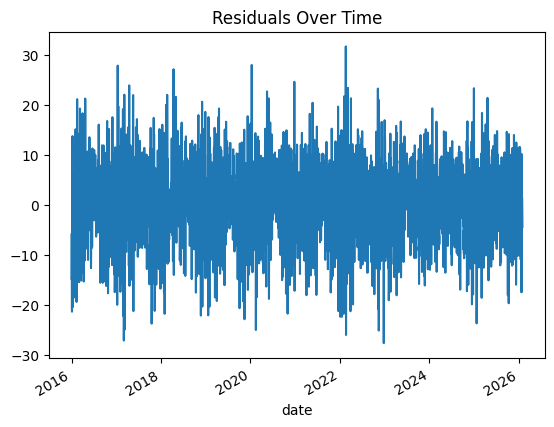

In [39]:
residuals = y_test - pred
residuals.plot(title="Residuals Over Time")

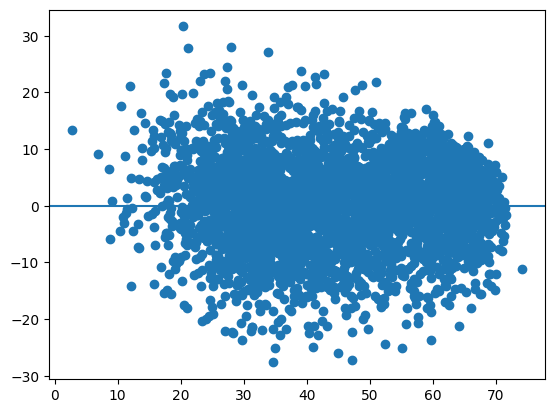

In [38]:
import matplotlib.pyplot as plt

plt.scatter(pred, residuals)
plt.axhline(0)

Residual diagnostics show no remaining linear structure, unducatung that theTide regression has captured most of the predictable signal in daily minimum temperature, and remaining error is dominated by stochastic weather varaibility.